In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [2]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [3]:
ids = tokenizer.encode('I hated this movie')
ids

[40, 16563, 428, 3807]

In [4]:
tokenizer.decode(ids)

'I hated this movie'

In [5]:
import torch

In [6]:
t = torch.LongTensor(ids)[None]
preds = model.generate(t)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [7]:
preds.shape,preds[0]

(torch.Size([1, 20]),
 tensor([   40, 16563,   428,  3807,    13,   314, 16563,   340,   523,   881,
           326,   314,  1422,   470,   772,  2342,   340,    13,   314,   373]))

In [8]:
tokenizer.decode(preds[0].numpy())

"I hated this movie. I hated it so much that I didn't even watch it. I was"

In [9]:
from fastai.text.all import *

#### Fine-tuning GPT-2 language model on Rotten Tomatoes Movie Reviews
Data source: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/overview

In [10]:
DATA_ROOT = Path("..") / "data/sentiment-analysis-on-movie-reviews"
df_train = pd.read_csv(DATA_ROOT / 'train.tsv', sep="\t")
df_valid = pd.read_csv(DATA_ROOT / 'test.tsv', sep="\t")

In [11]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [12]:
df_train["Phrase"]

0         A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
1                                                                                                                        A series of escapades demonstrating the adage that what is good for the goose
2                                                                                                                                                                                             A series
3                                                                                                                                                                                                    A
4                                                                                                                                                                                               series
     

In [13]:
all_texts = np.concatenate([df_train["Phrase"].values, df_valid["Phrase"].values])

In [14]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [15]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [16]:
tls.train[0],tls.valid[0]

(tensor([   32,  2168,   286,  3671,   499,  2367, 21135,   262,   512,   496,
           326,   644,   318,   922,   329,   262, 37246,   318,   635,   922,
           329,   262,   308,  4066,   837,   617,   286,   543, 10491,   716,
          2664,   475,  4844,   286,   543,  6867,   284,   881,   286,   257,
          1621,   764]),
 tensor([ 2025, 30598,  1473, 28790,   475,  4632,  8027,  3626,   764]))

In [17]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([42]), torch.Size([9]))

In [18]:
show_at(tls.train, 0)

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander, some of which occasionally amuses but none of which amounts to much of a story.


In [19]:
show_at(tls.valid, 0)

An intermittently pleasing but mostly routine effort.


In [20]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [21]:
dls.show_batch(max_n=2)

,text,text_
0,"90-minute moviewho embraces a strict moral codethat it even uses a totally unnecessary prologue, just because it seems obligatoryhard-heartedIt sounds like another clever if pointless excursion into the abyssmore X anda typical romantic triangleof a summer popcorn movieadd the magic that made it all workthe warsFranklin needs to stay afloat in Hollywoodmesmerizingmakes for perfectly acceptable, occasionally very enjoyable children's entertainment.After an hour and a half of wondering -- sometimes amusedly, sometimes impatiently -- just what this strenuously unconventional movie is supposed to bebefore it builds up to its insanely staged ballroom scene, in which 3000 actors appear in full regaliaThe ending doesn't work...the bucks to expend the full price for a date, but when it comes out on videoTo better understand why this didn't connect with me would require another viewing, and I won't be sitting through this one againcould make with a decent budgetbe resolved easily, or soonat any","-minute moviewho embraces a strict moral codethat it even uses a totally unnecessary prologue, just because it seems obligatoryhard-heartedIt sounds like another clever if pointless excursion into the abyssmore X anda typical romantic triangleof a summer popcorn movieadd the magic that made it all workthe warsFranklin needs to stay afloat in Hollywoodmesmerizingmakes for perfectly acceptable, occasionally very enjoyable children's entertainment.After an hour and a half of wondering -- sometimes amusedly, sometimes impatiently -- just what this strenuously unconventional movie is supposed to bebefore it builds up to its insanely staged ballroom scene, in which 3000 actors appear in full regaliaThe ending doesn't work...the bucks to expend the full price for a date, but when it comes out on videoTo better understand why this didn't connect with me would require another viewing, and I won't be sitting through this one againcould make with a decent budgetbe resolved easily, or soonat any"
1,"only -- killer website moviesurprisingly sweet and gentle-- to its own detriment -- muchit's not as obnoxious as Tom Green's Freddie Got Fingered's depressing to see how far Herzog has fallenIt's crap on a leash -- far too polite to scale the lunatic heights of Joe Dante's similarly styled Gremlins.'s a howler.this laughable dialogueactionfor its just under ninety minute running timekeep parents awaylabors so hard to whip life into The Importance of Being Earnest that he probably pulled a muscle or twoThough the aboriginal aspect lends the ending an extraordinary poignancy, and the story itself could be played out in any working class community in the nation.does a great combination act as narrator, Jewish grandmother and subject -- taking us through a film that is part biography, part entertainment and part historyA fiercely clever and subtle filmbroken legsSweet Homeabout coming to terms with deatha faulty premiseor `` suck ''this","-- killer website moviesurprisingly sweet and gentle-- to its own detriment -- muchit's not as obnoxious as Tom Green's Freddie Got Fingered's depressing to see how far Herzog has fallenIt's crap on a leash -- far too polite to scale the lunatic heights of Joe Dante's similarly styled Gremlins.'s a howler.this laughable dialogueactionfor its just under ninety minute running timekeep parents awaylabors so hard to whip life into The Importance of Being Earnest that he probably pulled a muscle or twoThough the aboriginal aspect lends the ending an extraordinary poignancy, and the story itself could be played out in any working class community in the nation.does a great combination act as narrator, Jewish grandmother and subject -- taking us through a film that is part biography, part entertainment and part historyA fiercely clever and subtle filmbroken legsSweet Homeabout coming to terms with deatha faulty premiseor `` suck ''this is"


#### Fine-tuning the model

In [22]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [23]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [24]:
learn.validate()

(#2) [2.2233810424804688,9.238513946533203]

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.14454397559165955)

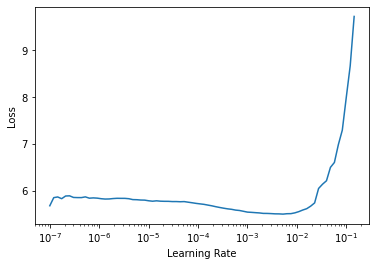

In [25]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.190694,2.643384,14.060704,13:48


In [27]:
df_valid.head(1)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .


In [28]:
prompt = "I hated this movie"

In [31]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 4])

In [33]:
preds = learn.model.generate(inp, max_length=40, num_beams=5, temperature=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [34]:
tokenizer.decode(preds[0].cpu().numpy())

"I hated this movie so much that I can't remember the last time I saw a movie that didn't make me want to crawl out of my seat and scream at the top of my lungs"